In [1]:
___Author___='LumberJack Jyss'

In [2]:
print('Global Optimized LumberJack Equities Method\n°OoO_FOREX_Oo0°\nLumberJack Jyss 5779(c)')

Global Optimized LumberJack Equities Method
°OoO_FOREX_Oo0°
LumberJack Jyss 5779(c)


In [3]:
print('Importing librairies...')
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score,roc_curve,confusion_matrix,classification_report
from keras.models import Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.utils import to_categorical
%matplotlib inline
print('Librairies imported')

Importing librairies...


Using TensorFlow backend.


Librairies imported


In [4]:
import warnings
import tensorflow as tf
warnings.filterwarnings("ignore")
tf.logging.set_verbosity(tf.logging.ERROR)

In [5]:
df_1D = pd.read_csv('data_prepared.csv')
df_1D = df_1D.iloc[:,1:]
df_1D = df_1D.dropna()
df_1D.reset_index(inplace=True,drop=True)

In [6]:
df_1D.isnull().sum().sum()

0

In [7]:
df_1D.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9951 entries, 0 to 9950
Data columns (total 23 columns):
Date                  9951 non-null object
Varop_Spy             9951 non-null float64
Varhl_spy             9951 non-null float64
RSI                   9951 non-null float64
75 - RSI              9951 non-null float64
RSI - 25              9951 non-null float64
BBD_Delta_Up          9951 non-null float64
delta5_8              9951 non-null float64
delta8_10             9951 non-null float64
delta10_12            9951 non-null float64
delta12_15            9951 non-null float64
delta15_30            9951 non-null float64
delta30_35            9951 non-null float64
delta35_40            9951 non-null float64
delta40_45            9951 non-null float64
delta45_50            9951 non-null float64
Peaks                 9951 non-null int64
Valley                9951 non-null int64
delta_tsf             9951 non-null float64
Forcast Oscillator    9951 non-null float64
target_up         

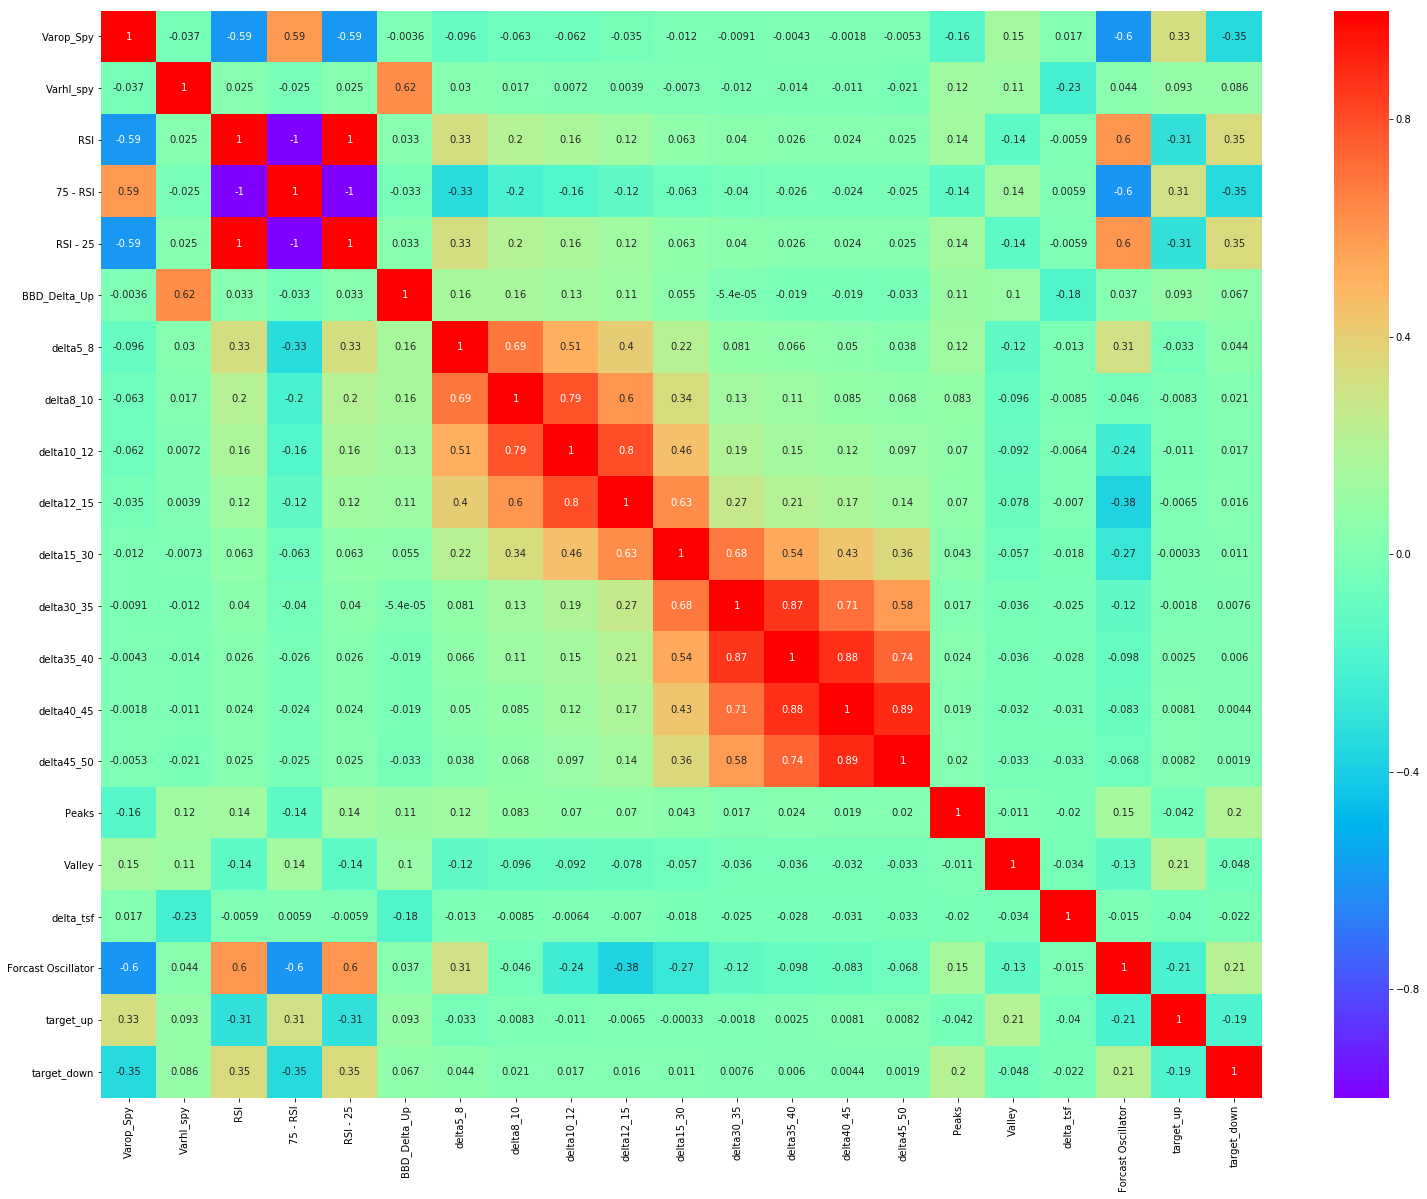

In [8]:
plt.figure(figsize=(26,20))
sns.heatmap(df_1D.iloc[:,:-1].corr(),annot=True,cmap='rainbow')
plt.show()

In [9]:
df_1D.shape

(9951, 23)

df_1D = df_1D.drop(['Peaks'],axis=1)
df_1D = df_1D.drop(['Valley'],axis=1)
df_1D.head()

In [10]:
df_1D['target_up'].sum(),df_1D['target_down'].sum()

(1427, 1762)

In [11]:
delta = round(df_1D.shape[0])
bloc1 = round(delta*0.8)
bloc2 = delta - bloc1
print("# of periods : ",delta)
print('On 80% - 20% slash : ')
print('Bloc 1 : ',bloc1,' periods (',df_1D.iloc[bloc1,0],')\nBloc 2 :',bloc2,' periods (',df_1D.iloc[bloc2,0],')')
print('First period :',df_1D.iloc[0,0])
print('Last period :',df_1D.iloc[df_1D.shape[0]-1,0])


# of periods :  9951
On 80% - 20% slash : 
Bloc 1 :  7961  periods ( 2019-06-11 02:53:00 )
Bloc 2 : 1990  periods ( 2019-06-04 16:42:00 )
First period : 2019-06-03 06:19:00
Last period : 2019-06-12 13:16:00


In [12]:
X = df_1D.iloc[:,1:-3]
#X = X.drop(['Peaks','Valley'],axis=1)
#X = X.drop(['75 - RSI','RSI - 25'],axis=1)
y_up = df_1D.iloc[:,-3].values
y_down = df_1D.iloc[:,-2].values


In [13]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9951 entries, 0 to 9950
Data columns (total 19 columns):
Varop_Spy             9951 non-null float64
Varhl_spy             9951 non-null float64
RSI                   9951 non-null float64
75 - RSI              9951 non-null float64
RSI - 25              9951 non-null float64
BBD_Delta_Up          9951 non-null float64
delta5_8              9951 non-null float64
delta8_10             9951 non-null float64
delta10_12            9951 non-null float64
delta12_15            9951 non-null float64
delta15_30            9951 non-null float64
delta30_35            9951 non-null float64
delta35_40            9951 non-null float64
delta40_45            9951 non-null float64
delta45_50            9951 non-null float64
Peaks                 9951 non-null int64
Valley                9951 non-null int64
delta_tsf             9951 non-null float64
Forcast Oscillator    9951 non-null float64
dtypes: float64(17), int64(2)
memory usage: 1.4 MB


In [14]:
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
#y_up = scaler.fit_transform(np.array(y_up).reshape(-1,1))
#y_down = scaler.fit_transform(np.array(y_down).reshape(-1,1))
y_up = np.array(y_up).reshape(-1,1)
y_down = np.array(y_down).reshape(-1,1)

In [15]:
X[:5,[6,7]]

array([[0.28316658, 0.33249896],
       [0.28554277, 0.31511612],
       [0.28891946, 0.28938951],
       [0.28591796, 0.29402494],
       [0.2897949 , 0.31205674]])

In [16]:
Xtrain = X[:bloc1,:]
Xtest = X[bloc1:,:]
ytrain_up = y_up[:bloc1,:]
ytest_up = y_up[bloc1:,:]
ytrain_down = y_down[:bloc1,:]
ytest_down = y_down[bloc1:,:]

In [17]:
Xtrain.shape,ytrain_up.shape,ytrain_down.shape,ytest_down.shape,ytest_up.shape

((7961, 19), (7961, 1), (7961, 1), (1990, 1), (1990, 1))

In [18]:
# fix random seed for reproducibility
seed = 770
np.random.seed(seed)

In [19]:
ytrain_up = ytrain_up.reshape(ytrain_up.shape[0],)
ytrain_down = ytrain_down.reshape(ytrain_down.shape[0],)

Xtrain = Xtrain.reshape(Xtrain.shape[0],Xtrain.shape[1])

model_up = Sequential()
# Add an input layer 
model_up.add(Dense(23, activation='relu'))
# Add one hidden layer 
model_up.add(Dense(50, activation='relu'))
# Add an output layer 
model_up.add(Dense(1, activation='sigmoid'))

model_down = Sequential()
# Add an input layer 
model_down.add(Dense(23, activation='relu'))
# Add one hidden layer 
model_down.add(Dense(50, activation='relu'))
# Add an output layer 
model_down.add(Dense(1, activation='sigmoid'))

In [20]:
print('Processing move_up')
model_up.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy','mse'])
                   
history_up = model_up.fit(Xtrain, ytrain_up,epochs=50, batch_size=32, verbose=0)

print('Processing move_down')
model_down.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy','mse'])
                   
history_down = model_down.fit(Xtrain, ytrain_down,epochs=50, batch_size=32, verbose=0)

print('Computing done')

Processing move_up
Processing move_down
Computing done


In [21]:
train_acc_up = model_up.evaluate(Xtrain, ytrain_up,verbose=1)
train_acc_down = model_down.evaluate(Xtrain, ytrain_down,verbose=1)
train_acc_up,train_acc_down

7961/7961 [==============================] - 0s 17us/step


([0.3232864660431191, 0.8596909936461792, 0.10299381911997939],
 [0.37114857318203376, 0.8282879034473495, 0.12044173610478456])

In [22]:
yhat_up = model_up.predict_classes(Xtest)
yhat_down = model_down.predict_classes(Xtest)

In [23]:
score_up = model_up.evaluate(Xtest, ytest_up,verbose=1)
score_down = model_down.evaluate(Xtest, ytest_down,verbose=1)
score_up,score_down

1990/1990 [==============================] - 0s 13us/step


([0.3054640392487373, 0.8834170854271357, 0.09358550214288222],
 [0.37638355313833033, 0.8326633166428188, 0.12146785250261201])

In [24]:
confusion_matrix(ytest_up, yhat_up),

(array([[1745,    4],
        [ 228,   13]]),)

In [25]:
confusion_matrix(ytest_down, yhat_down)

array([[1630,   27],
       [ 306,   27]])

In [26]:
predict_up = model_up.predict(Xtest)
predict_down = model_down.predict(Xtest)

In [27]:

accuracy_up = accuracy_score(ytest_up, yhat_up)
accuracy_down = accuracy_score(ytest_down, yhat_down)

# La précision permet de mesurer la capacité du modèle à refuser résultats non-pertinents : vrais_positifs/(vrais_positifs+faux_positifs)
precision_up = precision_score(ytest_up, yhat_up)  
precision_down = precision_score(ytest_down, yhat_down) 


# Recall : (vrai_positifs/(vrais_positifs+faux_négatifs))
recall_up = recall_score(ytest_up, yhat_up) 
recall_down = recall_score(ytest_down, yhat_down) 


roc_up=roc_auc_score(ytest_up,yhat_up)
roc_down=roc_auc_score(ytest_down,yhat_down)

In [28]:
print('RESULTATS UP\n')
print('Accuracy: %.2f%%' % (accuracy_up * 100.0))
print("Precision: %.2f%% " % (precision_up *100),' => Discrimnination des vrais positifs parmi les faux positifs')
print("Recall: %.2f%% " % (recall_up * 100),' => Positifs trouvés par Golem sur tous les positifs existants')
print("ROC: %.2f%% " % (roc_up *100))
# get probabilities for positive class

print(classification_report(ytest_up, yhat_up))
conf_matrix = pd.DataFrame(index = ['vrais_réels','Faux_réels'])
conf_matrix['Vrais_estimés'] = ['Vrais_positifs','Faux_positifs']
conf_matrix['Faux_estimés'] = ['Faux_négatif','Vrais-négatifs']
print(confusion_matrix(ytest_up, yhat_up))
print('Matrice de confusion :')
conf_matrix

RESULTATS UP

Accuracy: 88.34%
Precision: 76.47%   => Discrimnination des vrais positifs parmi les faux positifs
Recall: 5.39%   => Positifs trouvés par Golem sur tous les positifs existants
ROC: 52.58% 
              precision    recall  f1-score   support

           0       0.88      1.00      0.94      1749
           1       0.76      0.05      0.10       241

   micro avg       0.88      0.88      0.88      1990
   macro avg       0.82      0.53      0.52      1990
weighted avg       0.87      0.88      0.84      1990

[[1745    4]
 [ 228   13]]
Matrice de confusion :


,Vrais_estimés,Faux_estimés
vrais_réels,Vrais_positifs,Faux_négatif
Faux_réels,Faux_positifs,Vrais-négatifs


In [29]:
print('RESULTATS DOWN\n')
print('Accuracy: %.2f%%' % (accuracy_down * 100.0))
print("Precision: %.2f%% " % (precision_down *100),' => Discrimnination des vrais positifs parmi les faux positifs')
print("Recall: %.2f%% " % (recall_down * 100),' => Positifs trouvés par Golem sur tous les positifs existants')
print("ROC: %.2f%% " % (roc_down *100))
# get probabilities for positive class

print(classification_report(ytest_down, yhat_down))
conf_matrix = pd.DataFrame(index = ['vrais_réels','Faux_réels'])
conf_matrix['Vrais_estimés'] = ['Vrais_positifs','Faux_positifs']
conf_matrix['Faux_estimés'] = ['Faux_négatif','Vrais-négatifs']
print(confusion_matrix(ytest_down, yhat_down))
print('Matrice de confusion :')
conf_matrix

RESULTATS DOWN

Accuracy: 83.27%
Precision: 50.00%   => Discrimnination des vrais positifs parmi les faux positifs
Recall: 8.11%   => Positifs trouvés par Golem sur tous les positifs existants
ROC: 53.24% 
              precision    recall  f1-score   support

           0       0.84      0.98      0.91      1657
           1       0.50      0.08      0.14       333

   micro avg       0.83      0.83      0.83      1990
   macro avg       0.67      0.53      0.52      1990
weighted avg       0.78      0.83      0.78      1990

[[1630   27]
 [ 306   27]]
Matrice de confusion :


,Vrais_estimés,Faux_estimés
vrais_réels,Vrais_positifs,Faux_négatif
Faux_réels,Faux_positifs,Vrais-négatifs


In [30]:
df_1D.head(1)

,Date,Varop_Spy,Varhl_spy,RSI,75 - RSI,RSI - 25,BBD_Delta_Up,delta5_8,delta8_10,delta10_12,...,delta35_40,delta40_45,delta45_50,Peaks,Valley,delta_tsf,Forcast Oscillator,target_up,target_down,target_value
0,2019-06-03 06:19:00,0.54,0.81,2.807858,92.192142,-2.192142,1.674403,-0.5155,-0.1345,-0.136333,...,0.146286,0.156667,0.124733,0,0,2740.566703,-0.038811,0,0,2739.96


In [31]:
resultats = pd.DataFrame()
resultats['Date'] = df_1D.iloc[-bloc2:,0]
resultats['Move Up'] = yhat_up
resultats['Confiance up'] = (predict_up)*100
resultats['Move Down'] = yhat_down
resultats['Confiance Down'] = (predict_down)*100
resultats['Actual'] = df_1D['target_value']

In [32]:
resultats.head(50)

,Date,Move Up,Confiance up,Move Down,Confiance Down,Actual
7961,2019-06-11 02:53:00,0,2.991819,0,30.828274,2896.24
7962,2019-06-11 02:54:00,0,19.870523,0,7.580632,2895.98
7963,2019-06-11 02:55:00,0,19.979828,0,2.322921,2895.74
7964,2019-06-11 02:56:00,0,9.026668,0,24.831852,2895.88
7965,2019-06-11 02:57:00,0,0.701770,0,37.192638,2896.24
7966,2019-06-11 02:58:00,0,4.812345,0,25.798569,2896.14
7967,2019-06-11 02:59:00,0,0.810516,0,35.078949,2896.38
7968,2019-06-11 03:00:00,0,19.113609,0,10.040334,2896.10
7969,2019-06-11 03:01:00,0,18.447056,0,4.678959,2895.98
7970,2019-06-11 03:02:00,0,20.173021,0,1.234302,2895.82


In [33]:
len(resultats)

1990

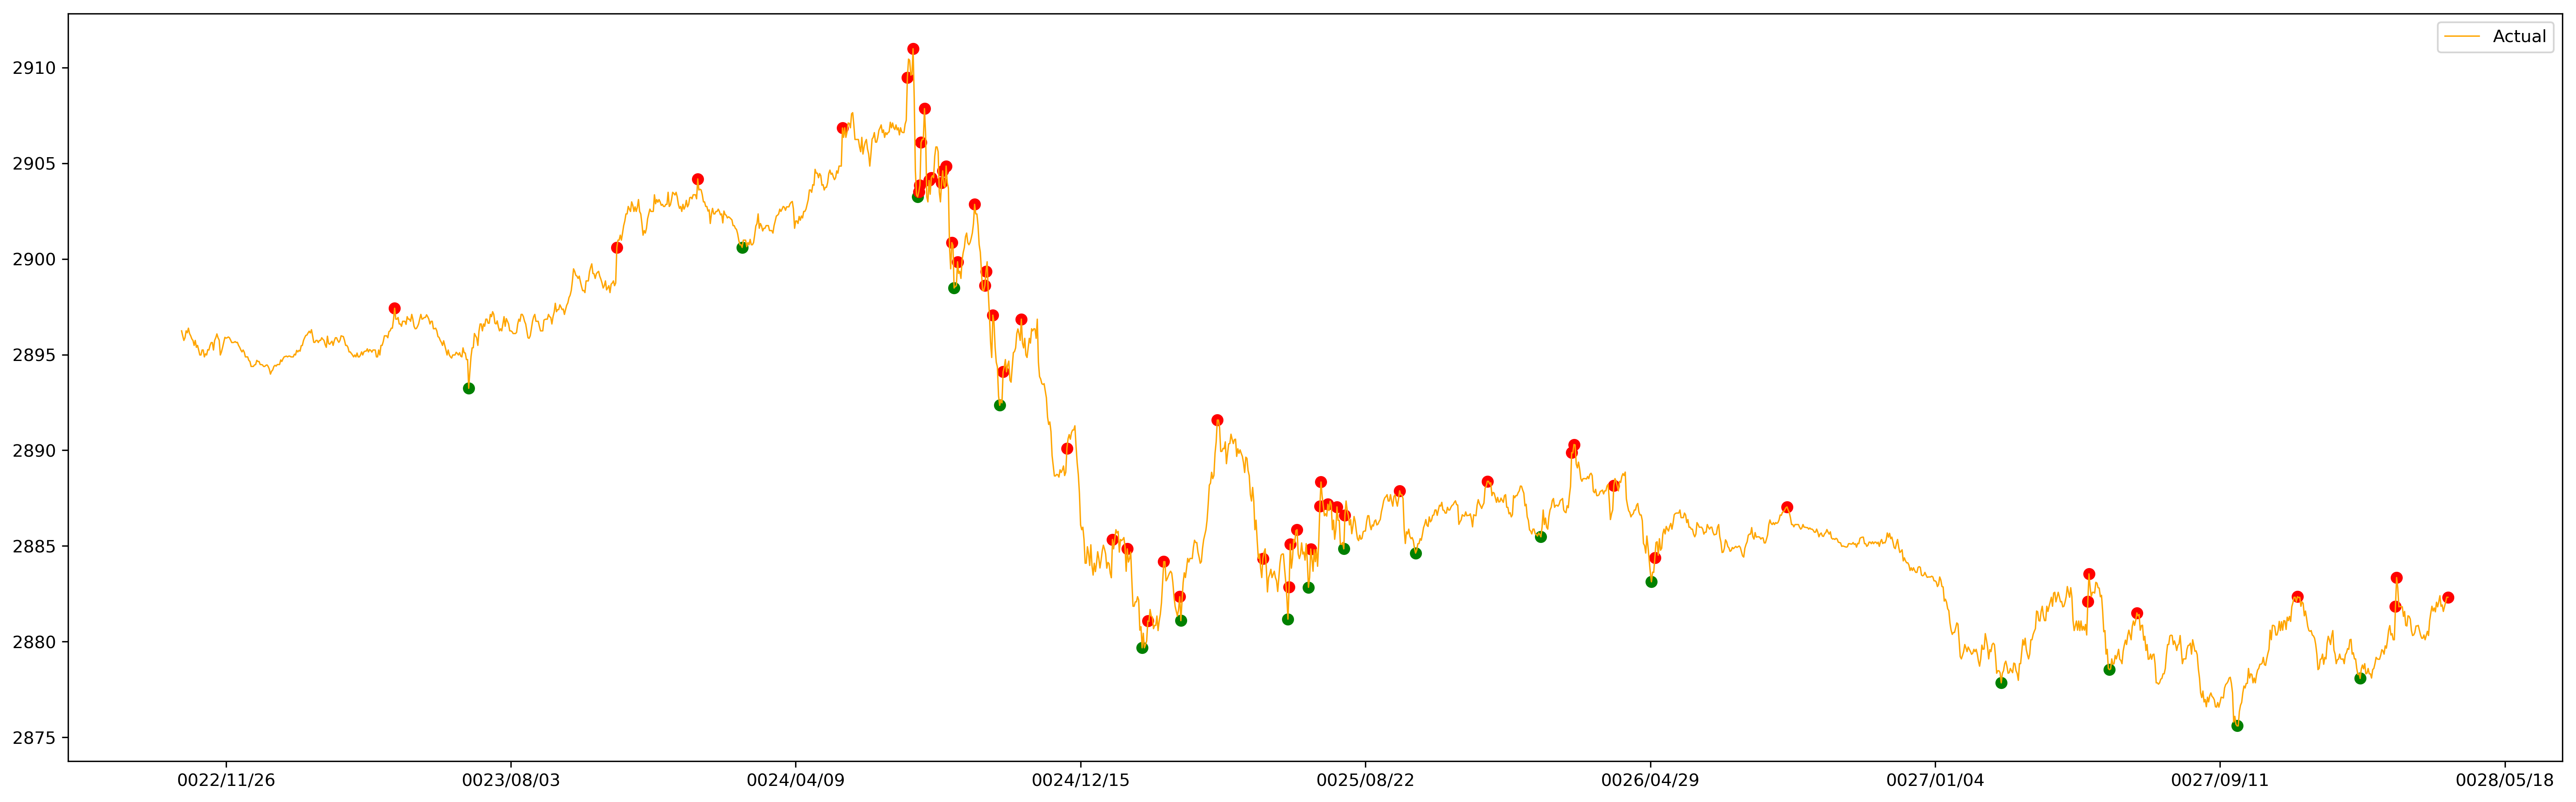

In [34]:
plt.figure(figsize=(26,8),dpi=300)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
plt.plot(resultats['Actual'],color='orange',lw=0.8)
a = -1
for i in range(0,len(resultats)):
    a+=1
    if resultats.iloc[a,1] == 1:
        plt.scatter(x=resultats.index[i],y=resultats.iloc[i,5],c='g',marker='o')
    elif resultats.iloc[a,3] == 1:
        plt.scatter(x=resultats.index[i],y=resultats.iloc[i,5],c='r',marker='o')
        
plt.legend()

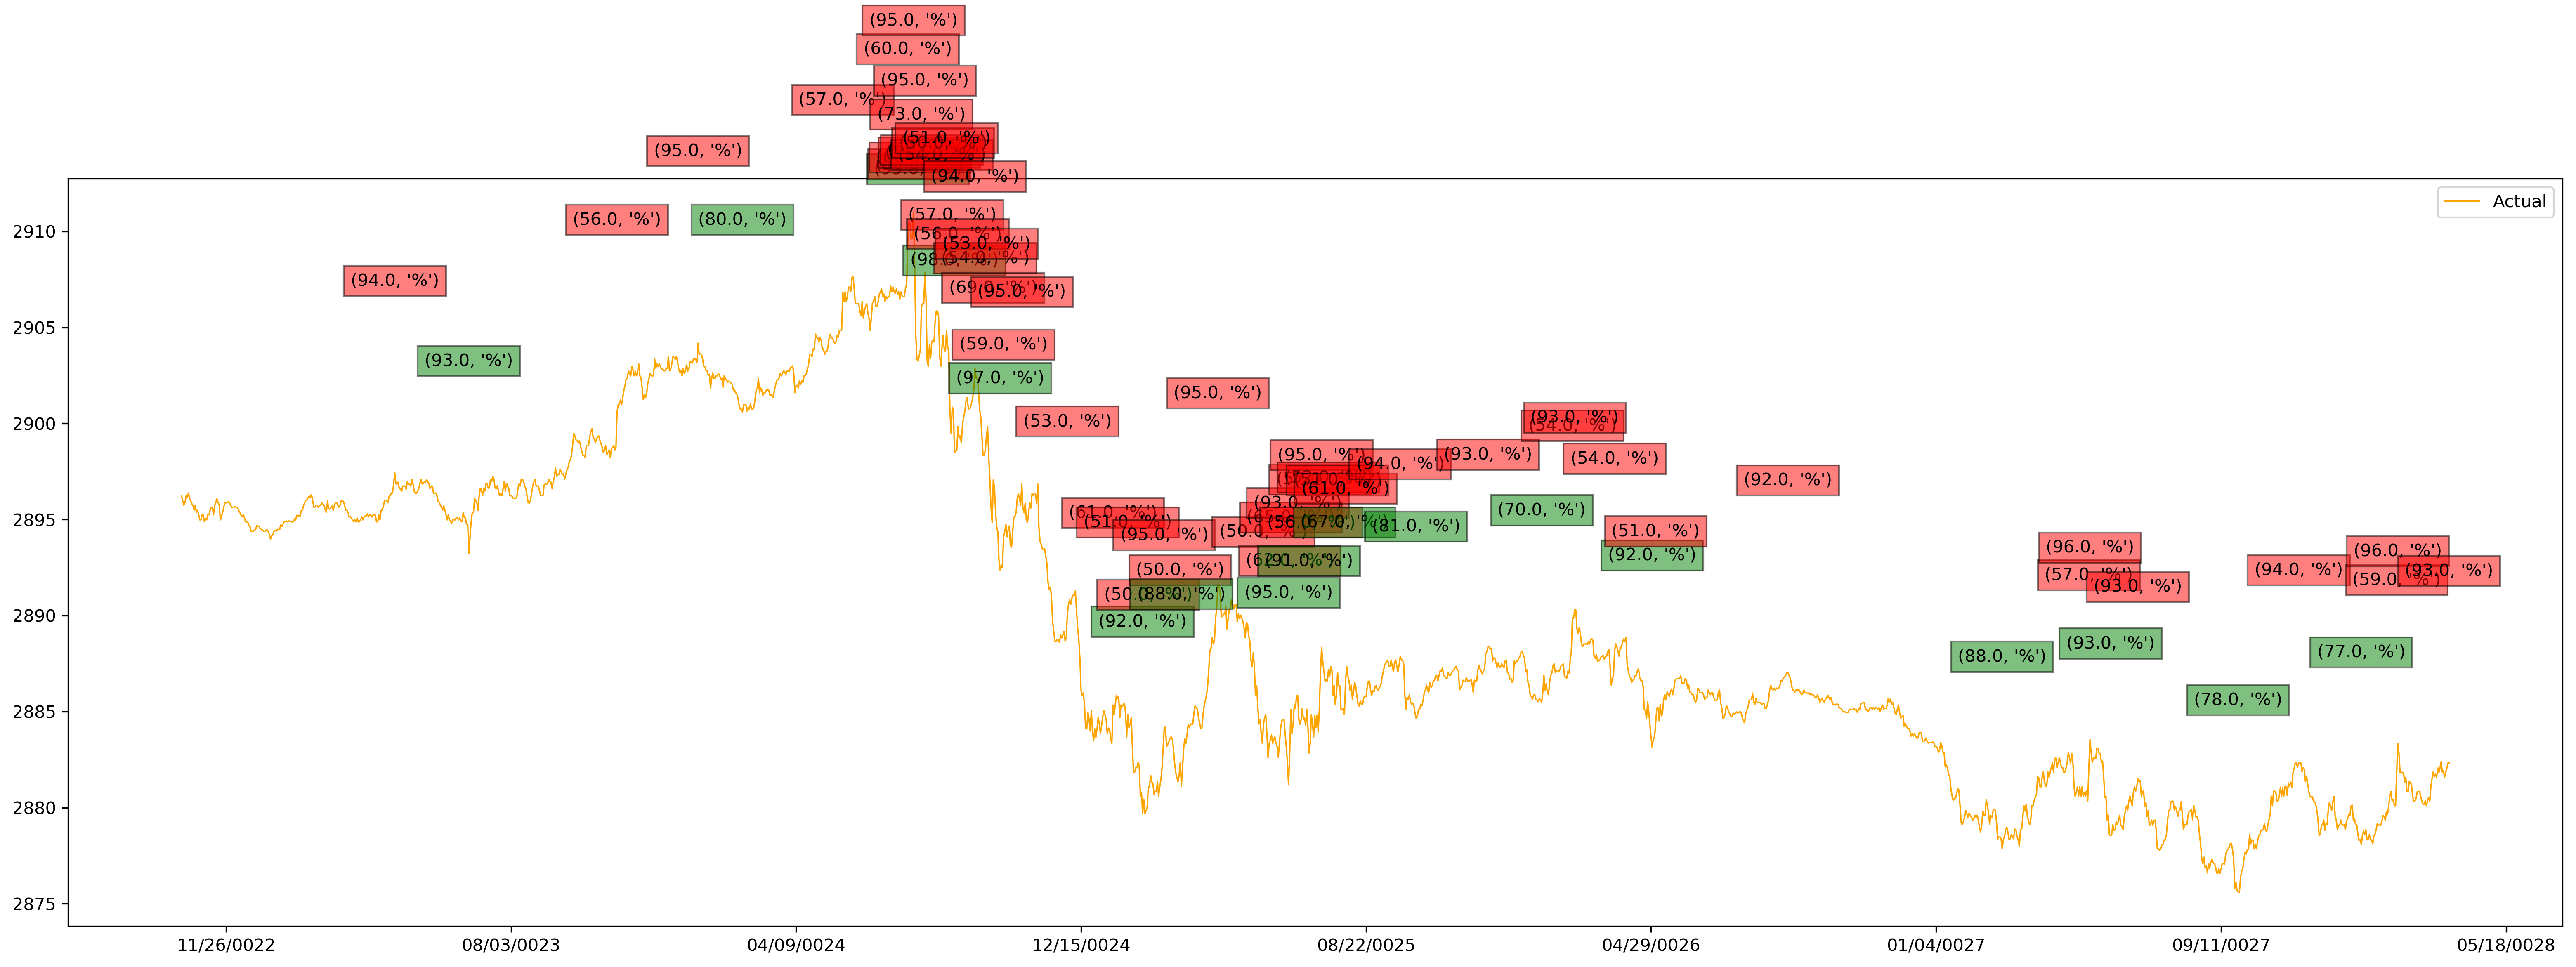

In [35]:
plt.figure(figsize=(26,8),dpi=300)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.plot(resultats['Actual'],color='orange',lw=0.8)
a = -1
for i in range(0,len(resultats)):
    a+=1
    if resultats.iloc[a,1] == 1:
        plt.text(x=resultats.index[i],y=resultats.iloc[i,5]+10,s=(round(resultats.iloc[i,2]),'%'), horizontalalignment = 'center', verticalalignment = 'center',
                bbox=dict(facecolor='green', alpha=0.5))
    elif resultats.iloc[a,3] == 1:
        plt.text(x=resultats.index[i],y=resultats.iloc[i,5]+10,s=(round(resultats.iloc[i,4]),'%'), horizontalalignment = 'center', verticalalignment = 'center',
                bbox=dict(facecolor='red', alpha=0.5))
plt.legend()

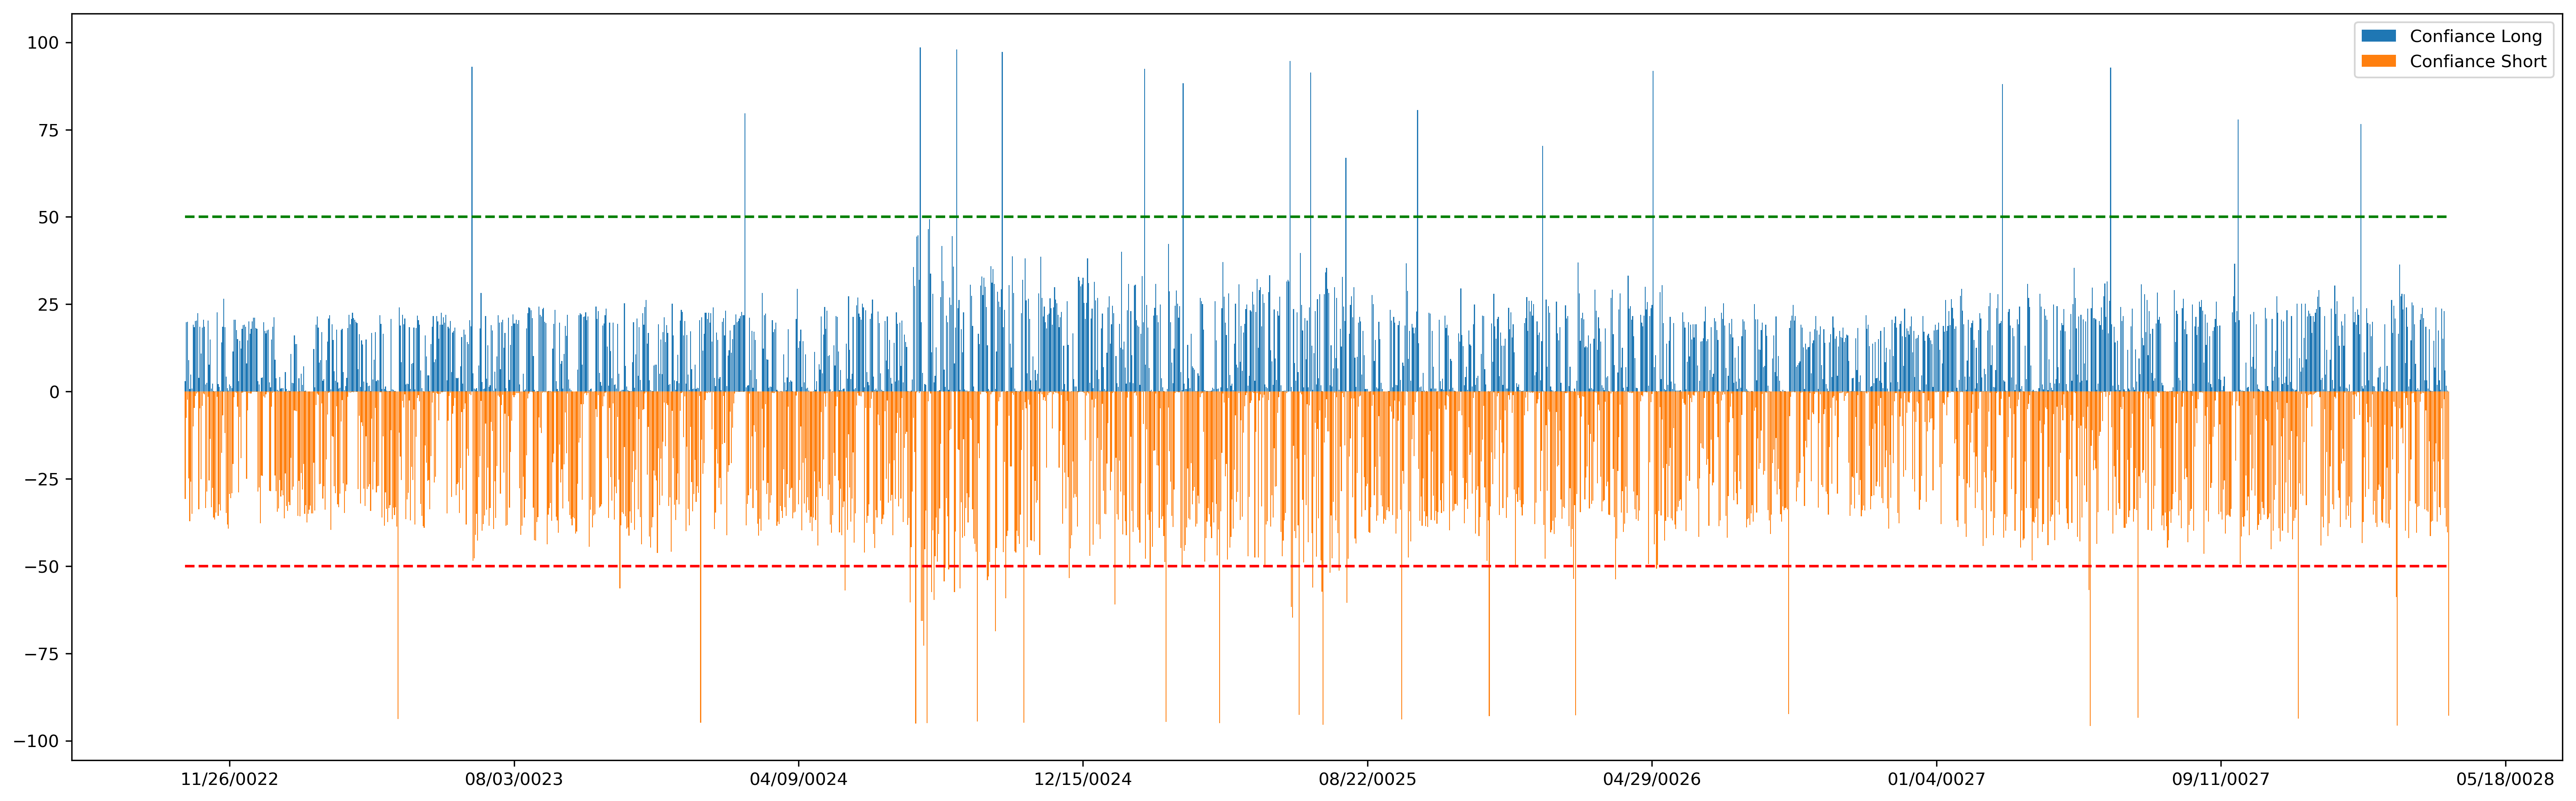

In [36]:
plt.figure(figsize=(26,8),dpi=300)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.bar(x=resultats.index,height=resultats['Confiance up'],label='Confiance Long')
plt.bar(x=resultats.index,height=-resultats['Confiance Down'],label='Confiance Short')
plt.hlines(xmin=resultats.index[0],xmax=resultats.index[-1],y=50,color='g',linestyles='--')
plt.hlines(xmin=resultats.index[0],xmax=resultats.index[-1],y=-50,color='r',linestyles='--')
plt.legend()

In [37]:
# save the model to disk
filename = 'finalized_model_long.sav'
pickle.dump(model_up, open(filename, 'wb'))
filename = 'finalized_model_short.sav'
pickle.dump(model_down, open(filename, 'wb'))

# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, Y_test)
print(result)

##### 